In [0]:
!pip install torch

In [0]:
!pip install torchvision

  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import numpy
import argparse
numpy.random.seed(8)
torch.manual_seed(8)
torch.cuda.manual_seed(8)
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy

# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        #print("Input size: "),
        #print(ten.shape)
        #print("Encoder block size: ",)
        if out:
            ten = self.conv(ten)
            #print(ten.size())
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            #print(ten.size())
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        #print("Input size: "),
        #print(ten.shape)
        #print("Decoder block size: ",)
        ten = self.conv(ten)
        #print(ten.size())
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(3):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//4))
        self.size = self.size//4
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),

        )

    def forward(self, ten,ten_original,ten_sampled):

        ten = torch.cat((ten, ten_original,ten_sampled), 0)

        for i, lay in enumerate(self.conv):
            # we take the 9th layer as one of the outputs
            if i == self.recon_levl:
                ten, layer_ten = lay(ten, True)
                # we need the layer representations just for the original and reconstructed,
                # flatten, because it's a convolutional shape
                layer_ten = layer_ten.view(len(layer_ten), -1)
            else:
                ten = lay(ten)

        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        return layer_ten,torch.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/numpy.sqrt(numpy.prod(m.weight.shape[1:]))
                    scale /=numpy.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant(m.bias, 0.0)

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            # encode
            mus, log_variances = self.encoder(ten)
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            # sample from a gaussian

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            # shift and scale using the means and variances

            ten = ten_from_normal * variances + mus
            # decode the tensor
            ten = self.decoder(ten)
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            #discriminator
            ten_layer,ten_class = self.discriminator(ten,ten_original,ten_from_normal)

            return ten, ten_class, ten_layer, mus, log_variances

        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten



    def __call__(self, *args, **kwargs):
        return super(VaeGan, self).__call__(*args, **kwargs)

    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted,layer_sampled, labels_original,
             labels_predicted,labels_sampled, mus, variances):
        """

        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers for both
        mse_1 = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        mse_2 = torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1)
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted+ 1e-3)

        #bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted+ 1e-3)
        '''
        

        bce_gen_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.ones_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_gen_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.ones_like(labels_sampled.data).cuda(), requires_grad=False))
        bce_dis_original = nn.BCEWithLogitsLoss(size_average=False)(labels_original,
                                        Variable(torch.ones_like(labels_original.data).cuda(), requires_grad=False))
        bce_dis_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.zeros_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_dis_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.zeros_like(labels_sampled.data).cuda(), requires_grad=False))
        '''
        return nle, kl, mse_1,mse_2,\
               bce_dis_original, bce_dis_sampled,bce_dis_recon,bce_gen_sampled,bce_gen_recon

In [0]:
# just a class to store a rolling average
# useful to log to TB
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0
    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [0]:
class MNIST(Dataset):
    def __init__(self,X,Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,index):
        return self.X[index],self.Y[index]

In [0]:
!pip install tensorboardX

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
import zipfile
import io
data = zipfile.ZipFile('mnist_png.zip', 'r')
data.extractall()

In [0]:
import numpy
import os
from torch.utils.data import Dataset, DataLoader
import cv2
from skimage import filters,transform

train_x_data=[]
train_y_data=[]

count=0

for number in range(10):
    file_directory="mnist_png/mnist_png/training/"+str(number)+"/"
    count=0
    for each_file in os.listdir(file_directory):
        if(count>500):
          break
        count+=1
        image=cv2.imread(file_directory+str(each_file))
        image=numpy.float64(image)
        image = cv2.resize(image, (64,64))
        h=image.shape[0]
        w=image.shape[1]
        for i in range(h):
          for j in range(w):
            image[i][j]=image[i][j]/255.0
        #image = numpy.stack((image,)*3, axis=-1)
        train_x_data.append(image)
        train_y_data.append(number)

In [0]:
print(len(train_x_data))

5010


In [0]:
dataset=MNIST(train_x_data, train_y_data)

In [0]:
z_size=128
recon_level=3
net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:193: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:195: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [0]:
import numpy
import os
from torch.utils.data import Dataset, DataLoader
import tensorboardX
from tensorboardX import SummaryWriter
import cv2
from skimage import filters,transform
#import progressbar
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

writer=SummaryWriter()

if __name__ == "__main__":

    dataset = MNIST(train_x_data, train_y_data)

    z_size = 128
    recon_level = 3
    decay_mse = 1.0
    decay_margin = 1.0
    n_epochs = 7
    lambda_mse = 1e-6
    lr = 0.001
    decay_lr = 0.75
    decay_equilibrium = 1.0
    
    # DATASET
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=1)
    dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=1)
    
    #margin and equilibirum
    margin = 0.35
    equilibrium = 0.68
    mse_lambda = 1.0
    # OPTIM-LOSS
    # an optimizer for each of the sub-networks, so we can selectively backprop
    optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    #lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
    lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
    optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
    #lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
    optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
    #lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

    batch_number = len(dataloader)
    step_index = 0
    for i in range(n_epochs):
        #progress = progressbar.ProgressBar(min_value=0, max_value=batch_number, initial_value=0, widgets=widgets).start()
        # reset rolling average
        print("Epoch number: ",i)
        loss_nle_mean = RollingMeasure()
        loss_encoder_mean = RollingMeasure()
        loss_decoder_mean = RollingMeasure()
        loss_discriminator_mean = RollingMeasure()
        loss_reconstruction_layer_mean = RollingMeasure()
        loss_kld_mean = RollingMeasure()
        gan_gen_eq_mean = RollingMeasure()
        gan_dis_eq_mean = RollingMeasure()
        #print("LR:{}".format(lr_encoder.get_lr()))

        # for each batch
        count=0
        for j, (data_batch,target_batch) in enumerate(dataloader):
            # set to train mode
            count+=len(data_batch)
            if(count%3000==0):
              print("count: ",count)
            train_batch = len(data_batch)
            data_batch=data_batch.transpose(2,3).transpose(1,2)
            net.train()
            # target and input are the same images
            data_target = Variable(data_batch, requires_grad=False).float().cuda()
            data_in = Variable(data_batch, requires_grad=False).float().cuda()

            # get output
            out, out_labels, out_layer, mus, variances = net(data_in)
            
            # split so we can get the different parts
            out_layer_predicted = out_layer[:train_batch]
            out_layer_original = out_layer[train_batch:-train_batch]
            out_layer_sampled = out_layer[-train_batch:]
            #labels
            out_labels_predicted = out_labels[:train_batch]
            out_labels_original = out_labels[train_batch:-train_batch]
            out_labels_sampled = out_labels[-train_batch:]
            # loss, nothing special here
            nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
            bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value= VaeGan.loss(data_target, out, out_layer_original,
                                                                         out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                          out_labels_predicted,out_labels_sampled, mus,
                                                                         variances)
            # THIS IS THE MOST IMPORTANT PART OF THE CODE
            loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1)+torch.sum(mse_value_2)
            loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)+ torch.sum(bce_dis_predicted_value)
            loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
            loss_decoder = torch.sum(lambda_mse/2 * mse_value_1)+ torch.sum(lambda_mse/2 * mse_value_2) + (1.0 - lambda_mse) * loss_decoder

            # register mean values of the losses for logging
            loss_nle_mean(torch.mean(nle_value).data.cpu().numpy())
            loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().numpy())
            loss_decoder_mean((torch.mean(lambda_mse * mse_value_1/2)+torch.mean(lambda_mse * mse_value_2/2) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).data.cpu().numpy())

            loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)+ torch.mean(mse_value_2)).data.cpu().numpy())
            loss_reconstruction_layer_mean((torch.mean(mse_value_1)+torch.mean(mse_value_2)).data.cpu().numpy())
            loss_kld_mean(torch.mean(kl_value).data.cpu().numpy())
            # selectively disable the decoder of the discriminator if they are unbalanced
            train_dis = True
            train_dec = True
            if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                train_dis = False
            if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                train_dec = False
            if train_dec is False and train_dis is False:
                train_dis = True
                train_dec = True

            #aggiungo log
            if train_dis:
                gan_dis_eq_mean(1.0)
            else:
                gan_dis_eq_mean(0.0)

            if train_dec:
                gan_gen_eq_mean(1.0)
            else:
                gan_gen_eq_mean(0.0)

            # BACKPROP
            # clean grads
            net.zero_grad()
            # encoder
            loss_encoder.backward(retain_graph=True)
            # someone likes to clamp the grad here
            #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
            # update parameters
            optimizer_encoder.step()
            # clean others, so they are not afflicted by encoder loss
            net.zero_grad()
            #decoder
            if train_dec:
                loss_decoder.backward(retain_graph=True)
                #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                optimizer_decoder.step()
                #clean the discriminator
                net.discriminator.zero_grad()
            #discriminator
            if train_dis:
                loss_discriminator.backward()
                #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                optimizer_discriminator.step()
        
        lr_encoder.step()
        lr_decoder.step()
        lr_discriminator.step()
        margin *=decay_margin
        equilibrium *=decay_equilibrium
        #margin non puo essere piu alto di equilibrium
        if margin > equilibrium:
            equilibrium = margin
        lambda_mse *=decay_mse
        if lambda_mse > 1:
            lambda_mse=1
        #progress.finish()
        
        writer.add_scalar('loss_encoder', loss_encoder_mean.measure, step_index)
        writer.add_scalar('loss_decoder', loss_decoder_mean.measure, step_index)
        writer.add_scalar('loss_discriminator', loss_discriminator_mean.measure, step_index)
        writer.add_scalar('loss_reconstruction', loss_nle_mean.measure, step_index)
        writer.add_scalar('loss_kld',loss_kld_mean.measure,step_index)
        writer.add_scalar('gan_gen',gan_gen_eq_mean.measure,step_index)
        writer.add_scalar('gan_dis',gan_dis_eq_mean.measure,step_index)
        
        testloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)
    
        for j, (data_batch,target_batch) in enumerate(testloader):
          if(j>1):
            break
          train_batch = len(data_batch)
          data_batch=data_batch.transpose(2,3).transpose(1,2)
          data_target = Variable(target_batch, requires_grad=False).float().cuda()
          data_in = Variable(data_batch, requires_grad=False).float().cuda()
          out, out_labels, out_layer, mus, variances = net(data_in)
          
        input_images=data_in.data.cpu().numpy()
        output_images=out.data.cpu().numpy()
        print(input_images[0][0])
        print(output_images[0][0])

Epoch number:  0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.00140453 0.00140457 0.00140456 ... 0.00140452 0.00140452 0.00140452]
 [0.00140449 0.00140455 0.00140449 ... 0.00140452 0.00140452 0.00140452]
 [0.00140453 0.00140457 0.00140456 ... 0.00140452 0.00140452 0.00140452]
 ...
 [0.00140442 0.00140442 0.00140445 ... 0.00140452 0.00140452 0.00140452]
 [0.00140439 0.00140442 0.00140441 ... 0.00140452 0.00140452 0.00140452]
 [0.00140441 0.00140439 0.00140438 ... 0.00140452 0.00140452 0.00140452]]
Epoch number:  1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-0.00076362 -0.00076354 -0.00076361 ... -0.00076365 -0.00076365
  -0.00076365]
 [-0.00076356 -0.00076353 -0.00076363 ... -0.00076365 -0.00076365
  -0.00076365]
 [-0.0007636  -0.00076358 -0.00076361 ... -0.000

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [0]:
x_input=[]
x_input = train_x_data[3400:3400+100]
x_input = torch.Tensor(x_input).cuda()
x_input = x_input.transpose(2,3).transpose(1,2)
out, out_labels, out_layer, mus, variances = net(x_input)

input_images = x_input.data.cpu().numpy()
output_images = out.data.cpu().numpy()

In [0]:
check=input_images[0][0]

maximum=check[0][0]

for i in range(len(check)):
  for j in range(len(check[0])):
    maximum=max(check[i][j],maximum)

print(maximum)    

0.9965801


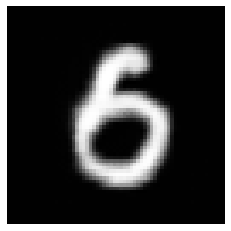

In [0]:
fig,ax = plt.subplots(1,1)
# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(output_images[38][1], cmap='gray')
fig.savefig('6_original.png')

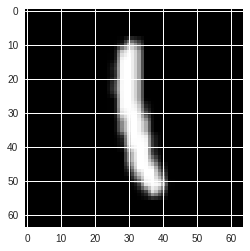

In [0]:
plt.imshow(input_images[71][1], cmap='gray')